In [ ]:
!pip install pickle5

# Лекция №4
# Тема: Линейная регрессия. Метод опорных векторов в задачах регрессии. Метод наименьших квадратов. 

## Постановка задачи

Всем привет! Мы подготовили для вас реальный датасет с заказами пользователей на платформе  Delivery Club. Этот датасет включает данные за 2020-2021 год для пяти районов одного города. Эти районы не похожи друг на друга и  отличаются по площади, популярности и количеству заказов в день. Теперь мы загрузим датасет и рассмотрим его по-внимательней. Видим, что в данном датасете каждому району, дню и часу соответствует определённое кол-во заказов. В рамках практического занятия нужно будет предсказать кол-во заказов на неделю вперёд в разрезах район – день – час. Для предсказания мы будем использовать разные типы моделей (линейную регрессию и SVR), оценим качество, полученное с помощью каждой из моделей и сделаем выводы на их основе.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import output
from google.colab import files
import zipfile
import io
output.enable_custom_widget_manager()
uploaded = files.upload()
data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')
data.extractall()

Saving data.zip to data (2).zip


In [ ]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = "colab"

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pickle5 as pickle
with open('data/forecast_orders_X.pkl', "rb") as fh:
    X = pickle.load(fh)
with open('data/forecast_orders_y.pkl', "rb") as fh:
    y = pickle.load(fh)
df = X.copy()
df['orders'] = y

## EDA (Exploratory Data Analysis)

In [ ]:
# Кол-во уникальных регионов
df['region_id'].unique()

array([1, 2, 3, 4, 5])

In [ ]:
df['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
df['date'].nunique()

365

In [ ]:
df.shape

(43800, 5)

In [ ]:
5*365*24

43800

In [ ]:
df[df[['date', 'region_id', 'hour']].duplicated()]

,region_id,date,hour,type,orders


In [ ]:
# Информация о пустых значениях и типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   region_id  43800 non-null  int64 
 1   date       43800 non-null  object
 2   hour       43800 non-null  int64 
 3   type       43800 non-null  object
 4   orders     43800 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.7+ MB


In [ ]:
df.describe()

,region_id,hour,orders
count,43800.00000,43800.000000,43800.000000
mean,3.00000,11.500000,11.829041
std,1.41423,6.922266,16.169203
min,1.00000,0.000000,0.000000
25%,2.00000,5.750000,0.000000
50%,3.00000,11.500000,6.000000
75%,4.00000,17.250000,18.000000
max,5.00000,23.000000,117.000000


In [ ]:
# График заказов по регионам
group = df[['date', 'region_id', 'orders']].groupby(['date', 'region_id'], as_index=False).sum()
fig = px.line(group, x="date", y="orders", color='region_id', template='plotly_dark')
fig.update_layout(
    title={
        'text': "Количество заказов по регионам",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show() 

In [ ]:
# Распределение заказов по часам
group = df[['orders', 'hour']].groupby('hour', as_index=False).sum()
fig = px.bar(group, x='hour', y='orders', template='plotly_dark')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    ),
    title={
        'text': "Распределение заказов по часам",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
# Распределение заказов по часам и регионам
group = df[['orders', 'hour', 'region_id']].groupby(['hour', 'region_id'], as_index=False).sum()
group['region_id'] = group['region_id'].astype(str)
fig = px.bar(group, x='hour', y='orders', color='region_id', barmode='group', template='plotly_dark')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    ),
    title={
        'text': "Распределение заказов по часам и регионам",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_xaxes(range=[7, 23], row=1, col=1)
fig.show()

In [ ]:
# Добавим дополнительные колонки, укажем выходной день или нет и укажем день недели
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df.date.dt.weekday # день недели
df['weekend'] = df['weekday'].isin([5, 6]).astype(int) # выходной день

In [ ]:
# Распределение заказов по дням недели
group = df[['orders', 'weekday']].groupby('weekday', as_index=False).sum()
fig = px.bar(group, x='weekday', y='orders', template='plotly_dark')
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(7)),
        ticktext = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
    ),
    title={
        'text': "Распределение заказов по дням недели",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
# Распределение заказов по дням недели и регионам
group = df[['orders', 'weekday', 'region_id']].groupby(['weekday', 'region_id'], as_index=False).sum()
group['region_id'] = group['region_id'].astype(str)
fig = px.bar(group, x='weekday', y='orders', color='region_id', barmode='group', template='plotly_dark')
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(7)),
        ticktext = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
    ),
    title={
        'text': "Распределение заказов по дням недели и регионам",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
# Дневной профиль заказов для выходных и будних дней
group=df[['orders', 'hour', 'weekend']].groupby(['hour', 'weekend'], as_index=False).mean()
group['weekend'] = group['weekend'].astype(str)
fig = px.bar(group, x='hour', y='orders', color='weekend', barmode='group', template='plotly_dark')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    ),
    title={
        'text': "Дневной профиль заказов для выходных и будних дней",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_layout(barmode='group')
fig.show()

Как мы видим, все заказы в основном сосредоточены с 9 до 22 часов. В остальные часы заказов настолько мало, что они даже не отображаются на графике. Таким образом, при предсказании заказов можно просто занулять непопулярные часы, это может улучшить качество предсказания. На графике распределения заказов мы видим, что количество заказов зависит от дня недели, по выходным и в пятницу обычно больше заказов, чем в будние дни. Ещё дневной профиль заказов, как мы видим, тоже отличается, для будних и выходных дней: в выходные дни нет ярко выраженного вечернего и утреннего пика, как на будних днях. 

## Feature Engineering

Помимо временных признаков очень хорошо работают для предсказания — лаговые фичи. Эти фичи основанным на историческом значении количества заказов, например, количество заказов неделю назад. Добавим такие лаговые фичи от 7 до 14 дней назад. Добавлять лаги до 7 дней не имеет смысла, так как у нас горизонт планирования — неделя. Также по опыту хорошо заходят лаговые агрегированные фичи, такие как среднее число заказов 1 неделю и 2 недели назад. В данном случае мы добавляем взвешенное среднее с большим вкладом более свежих данных. Ещё добавим суммарное количество заказов за день неделю назад. Вообще, лаговых фичей можно придумать большое количество, хватило бы фантазии. Например, такие фичи как среднее/суммарное количество заказов, подсчитанное за окно в пять часов неделю назад. 

In [ ]:
# Добавим лаговые фичи от 7 до 14 дней
df = df.sort_values(['region_id', 'date', 'hour']).reset_index(drop=True)
group = df.groupby(['hour', 'region_id'])
for i in range(7, 15):
    df[f'lag_day_{i}'] = group['orders'].shift(i)

In [ ]:
df[(df['region_id'] == 3) & (df['hour'] == 14)].iloc[-14:]

,region_id,date,hour,type,orders,weekday,weekend,lag_day_7,lag_day_8,lag_day_9,lag_day_10,lag_day_11,lag_day_12,lag_day_13,lag_day_14
25958,3,2021-06-17,14,train,62,3,0,39.0,49.0,56.0,47.0,68.0,72.0,59.0,47.0
25982,3,2021-06-18,14,train,90,4,0,59.0,39.0,49.0,56.0,47.0,68.0,72.0,59.0
26006,3,2021-06-19,14,train,49,5,1,47.0,59.0,39.0,49.0,56.0,47.0,68.0,72.0
26030,3,2021-06-20,14,train,75,6,1,58.0,47.0,59.0,39.0,49.0,56.0,47.0,68.0
26054,3,2021-06-21,14,train,51,0,0,73.0,58.0,47.0,59.0,39.0,49.0,56.0,47.0
26078,3,2021-06-22,14,train,65,1,0,54.0,73.0,58.0,47.0,59.0,39.0,49.0,56.0
26102,3,2021-06-23,14,train,67,2,0,77.0,54.0,73.0,58.0,47.0,59.0,39.0,49.0
26126,3,2021-06-24,14,test,51,3,0,62.0,77.0,54.0,73.0,58.0,47.0,59.0,39.0
26150,3,2021-06-25,14,test,63,4,0,90.0,62.0,77.0,54.0,73.0,58.0,47.0,59.0
26174,3,2021-06-26,14,test,66,5,1,49.0,90.0,62.0,77.0,54.0,73.0,58.0,47.0


In [ ]:
# Взвешенное количество заказов за 2 недели
weights = np.array([0.7, 0.3])
df['2_weeks_mean'] = np.sum(df[['lag_day_7', 'lag_day_14']] * weights, axis=1)

In [ ]:
# Суммарное количество заказов за день неделю назад
tmp = df.groupby(['region_id', 'date'])['lag_day_7'].sum().reset_index()
tmp.rename(columns={'lag_day_7': 'orders_sum'}, inplace=True)
df = df.merge(tmp, on=['region_id', 'date'], how='left')

In [ ]:
df[(df['region_id'] == 3) & (df['date'] == pd.Timestamp('2021-06-30 00:00:00'))].iloc[:1]

,region_id,date,hour,type,orders,weekday,weekend,lag_day_7,lag_day_8,lag_day_9,lag_day_10,lag_day_11,lag_day_12,lag_day_13,lag_day_14,2_weeks_mean,orders_sum
26256,3,2021-06-30,0,test,6,2,0,4.0,7.0,9.0,14.0,6.0,11.0,5.0,9.0,5.5,750.0


In [ ]:
df[(df['region_id'] == 3) & (df['date'] == pd.Timestamp('2021-06-23 00:00:00'))]['orders'].sum()

750

### One-Hot Encoding
Предположим, что некоторый признак может принимать 10 разных значений. В этом случае One Hot Encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. На позицию, соответствующую численному значению признака мы помещаем 1.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1pI78Fsu9DuPmUMaml_4yYk17LQTcahy5" width="600">
</p>

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1PgBBcuXOqyOgrkORaagUBZgBkrvbEeS2" width="600">
</p>

In [ ]:
s = pd.Series(list('abca'))
pd.DataFrame(s)

,0
0,a
1,b
2,c
3,a


In [ ]:
pd.get_dummies(s)

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0


In [ ]:
# Предобработка категориальных фичей, используем one-hot encoding
df = pd.concat((df, pd.get_dummies(df.weekday, prefix='wd')), axis=1)
df = pd.concat((df, pd.get_dummies(df.hour, prefix='h')), axis=1)
df = pd.concat((df, pd.get_dummies(df.region_id, prefix='reg')), axis=1)

In [ ]:
# Разбиваем данные на train и test
train_df = df[df['type'] == 'train'].copy().dropna().reset_index(drop=True)
test_df = df[df['type'] == 'test'].copy().reset_index(drop=True)
train_df = train_df.sort_values(['date', 'hour', 'region_id']).reset_index(drop=True)
test_df = test_df.sort_values(['date', 'hour', 'region_id']).reset_index(drop=True)

### Метрики качества

- MAE — средняя абсолютная ошибка, показывает на сколько заказов в среднем ошибается прогноз. Это метрика очень легко интерпретируема. Если у нас значение метрики равно, например, 5, то это значит модель в среднем ошибается на 5 заказов каждый час по каждому району. Метрика не бывает отрицательной, так как все ошибки беруться по модулю, для идеальной модели эта метрика будет равна 0. Метрика не так чувствительна к выбросам.

$$MAE = \frac1N \sum ^{N}_{i=1} |y_i-\hat y_i|$$

- MSE — средняя квадратическая ошибка. По сути тоже самое, что и MAE, только величина ошибки берется в квадрате. Это существенно снижает её интерпретируемость. К тому же эта метрика менее устойчива к выбросам. Одна большая ошибка в прогнозе может сильно завысить показания этой метрики.

$$MSE = \frac1N \sum ^{N}_{i=1} (y_i-\hat y_i)^2$$

- MAPE — относительная метрика. Тоже что и MAE, только нормируется на реальное значение прогноза. Говорит нам на сколько процентов в среднем мы ошибаемся. Эта метрика хорошо интерпретируема и всем понятна.

$$MAPE = \frac{100%}{N}  \sum ^{N}_{i=1} |\frac{y_i-\hat y_i}{y_i}|$$

- MASE — это метрика по которой можно понять насколько наш прогноз точнее наивного прогноза. В нашем случае, наивный прогноз — это количество заказов неделю назад. То есть прогноз наивной модели это просто исторические данные за предыдущий период. Эта метрика хорошо интрепретируема и показывает «обоснованность» использования модели. Если мы сделали супер сложную модель и MASE при этом больше или равна 1, то не имеет никакого смысла использовать эту модель. Легче просто брать последнее историческое значение, там будет прогноз точнее.

$$MASE = \frac{MAE}{MAE_{naive}}$$

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def metric_mape(y_valid: list, val_pred: list) -> float:
    """
    Calculate MAPE metric

    :param y_valid: list, real values
    :param val_pred: list, predicted values
    :return: float, MAPE metric
    """
    y_valid = np.array(y_valid).reshape(-1)
    val_pred = np.array(val_pred)
    return np.sum(np.abs(y_valid - val_pred)) / np.sum(y_valid) * 100


def calculate_metrics(df: pd.DataFrame,
                      forecast_name='forecast') -> (float, float, float,
                                                    float, float, float):
    """
    Calculate metrics

    :param df: pd.DataFrame, result dataframe
    :return:
    """
    y_true = df.orders
    y_pr = df[forecast_name]
    y_naive = df.lag_day_7

    mae = mean_absolute_error(y_true, y_pr)
    mse = mean_squared_error(y_true, y_pr)
    mae_naive = mean_absolute_error(y_true, y_naive)

    mape = metric_mape(y_true, y_pr)

    mase = mae / mae_naive

    print(f"MAE: {mae:.2f}\n"
          f"MSE: {mse:.2f}\n"
          f"MAPE: {mape:.2f} %\n"
          f"MASE: {mase:.2f}\n")

In [ ]:
from sklearn.preprocessing import StandardScaler

### StandardScaler

Многие алгоритмы машинного обучения работают лучше или сходятся быстрее, когда функции находятся в относительно одинаковом масштабе и/или близки к нормальному распределению.

$$z = \frac{x - \mu}{s}$$
$$\mu - \text{математическое ожидание}$$
$$s - \text{среднеквадратическое отклонение}$$
$$x - \text{исходная переменная}$$

In [ ]:
# Используемые фичи
list(train_df.columns)

['region_id',
 'date',
 'hour',
 'type',
 'orders',
 'weekday',
 'weekend',
 'lag_day_7',
 'lag_day_8',
 'lag_day_9',
 'lag_day_10',
 'lag_day_11',
 'lag_day_12',
 'lag_day_13',
 'lag_day_14',
 '2_weeks_mean',
 'orders_sum',
 'wd_0',
 'wd_1',
 'wd_2',
 'wd_3',
 'wd_4',
 'wd_5',
 'wd_6',
 'h_0',
 'h_1',
 'h_2',
 'h_3',
 'h_4',
 'h_5',
 'h_6',
 'h_7',
 'h_8',
 'h_9',
 'h_10',
 'h_11',
 'h_12',
 'h_13',
 'h_14',
 'h_15',
 'h_16',
 'h_17',
 'h_18',
 'h_19',
 'h_20',
 'h_21',
 'h_22',
 'h_23',
 'reg_1',
 'reg_2',
 'reg_3',
 'reg_4',
 'reg_5']

In [ ]:
# Числовые фичи
num_features = ['lag_day_7', 'lag_day_8', 'lag_day_9', 'lag_day_10','lag_day_11', 'lag_day_12', 
                'lag_day_13', 'lag_day_14', '2_weeks_mean', 'orders_sum']
# Категориальные фичи
cat_features = ['weekend', 'wd_0', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6',
                'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9',
                'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18',
                'h_19', 'h_20', 'h_21', 'h_22', 'h_23', 'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5']

# Таргеты
y_train = train_df.orders
y_test = test_df.orders

# Категориальные фичи
X_train_cat = train_df[cat_features].values
X_test_cat = test_df[cat_features].values

# Скалируем числовые фичи
X_train_num = train_df[num_features].copy()
X_test_num = test_df[num_features].copy()
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# Итоговые датасеты для обучения
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

## Построение модели и анализ результатов

### TimeSeriesSplit
<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1KhtJXlhp0-CYrfOJg4HWOw6xF1BnjH12" width="700">
</p>

In [ ]:
import IPython
IPython.display.HTML(filename='data/ML_Sunburst.html')

Output hidden; open in https://colab.research.google.com to view.

### Линейная регрессия
Линейная регрессия (Linear regression) — модель с линейной функцией зависимости переменной (таргета) от одной или нескольких других переменных (признаков).
$$y = w_0 + \sum_{i=1}^m w_i x_i $$
$$y - \text{целевая переменная (таргет)}$$
$$x_i - \text{i-ый признак}$$
$$w_i - \text{вес i-ого признака}$$

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")


In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('SVR', SVR()))
results = []
model_names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=4)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    model_names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.891093 (0.019688)
SVR: 0.873087 (0.025462)


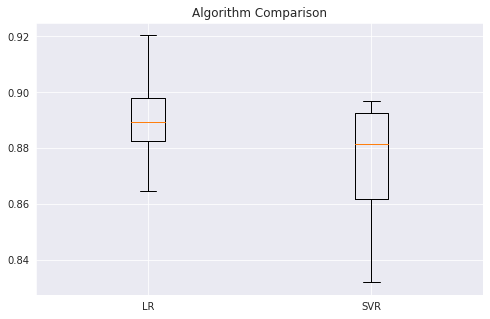

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(results, labels=model_names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
# Обучаем линейную регрессию
model = LinearRegression()
model.fit(X_train, y_train)
forecast = model.predict(X_test)
test_df['forecast_lr'] = forecast

# Обучаем SVR
model = SVR()
model.fit(X_train, y_train)
forecast = model.predict(X_test)
test_df['forecast_svr'] = forecast

In [ ]:
calculate_metrics(test_df, forecast_name='forecast_lr')

MAE: 3.55
MSE: 35.63
MAPE: 22.31 %
MASE: 0.90



In [ ]:
calculate_metrics(test_df, forecast_name='forecast_svr')

MAE: 3.51
MSE: 40.37
MAPE: 22.02 %
MASE: 0.89



In [ ]:
# Зануляем все непопулярные часы
test_df['forecast_lr_zero'] = test_df['forecast_lr']
test_df.loc[((test_df.hour <= 6) & (test_df.hour >= 4)), 'forecast_lr_zero'] = 0
test_df['forecast_lr_zero'] = [max(0, i) for i in test_df['forecast_lr_zero']]

test_df['forecast_svr_zero'] = test_df['forecast_svr']
test_df.loc[((test_df.hour <= 6) & (test_df.hour >= 4)), 'forecast_svr_zero'] = 0
test_df['forecast_svr_zero'] = [max(0, i) for i in test_df['forecast_svr_zero']]

In [ ]:
calculate_metrics(test_df, forecast_name='forecast_lr_zero')

MAE: 3.43
MSE: 35.53
MAPE: 21.57 %
MASE: 0.87



In [ ]:
calculate_metrics(test_df, forecast_name='forecast_svr_zero')

MAE: 3.49
MSE: 40.36
MAPE: 21.89 %
MASE: 0.89



In [ ]:
# Соедниним день и час
test_df['time'] = [dt + pd.Timedelta(f'{h}h') for dt, h in zip(test_df['date'],
                                                               test_df['hour'])]


In [ ]:
forecast_name = 'forecast_lr_zero'
for i in test_df.region_id.unique():
    pl = test_df[test_df.region_id == i][['orders', forecast_name, 'time']]
    fig = go.Figure([
        go.Scatter(x=pl['time'], y=pl['orders'], name='fact', mode='lines'),
        go.Scatter(x=pl['time'], y=pl[forecast_name], name='prediction', mode='lines'),
    ], layout=go.Layout(template='plotly_dark',
        title=go.layout.Title(text=f"Region {i}")
    ))
    fig.show()